In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip gdrive/My\ Drive/dataset/train.zip 

Archive:  gdrive/My Drive/dataset/train.zip
replace train/AFRICAN CROWNED CRANE/001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam

from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional
from google.colab import drive

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 16)

Found 45980 images belonging to 315 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/gdrive/MyDrive/dataset/valid',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 16)

Found 1575 images belonging to 315 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/gdrive/MyDrive/dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 16)

Found 1575 images belonging to 315 classes.


In [ ]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights="imagenet", classes=315)

In [ ]:
# Freezing Layers

for layer in base_model.layers[:-8]:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(315,activation='softmax'))

In [ ]:
# Model Summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_4 (Batc  (None, 25088)            100352    
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                802848    
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                      

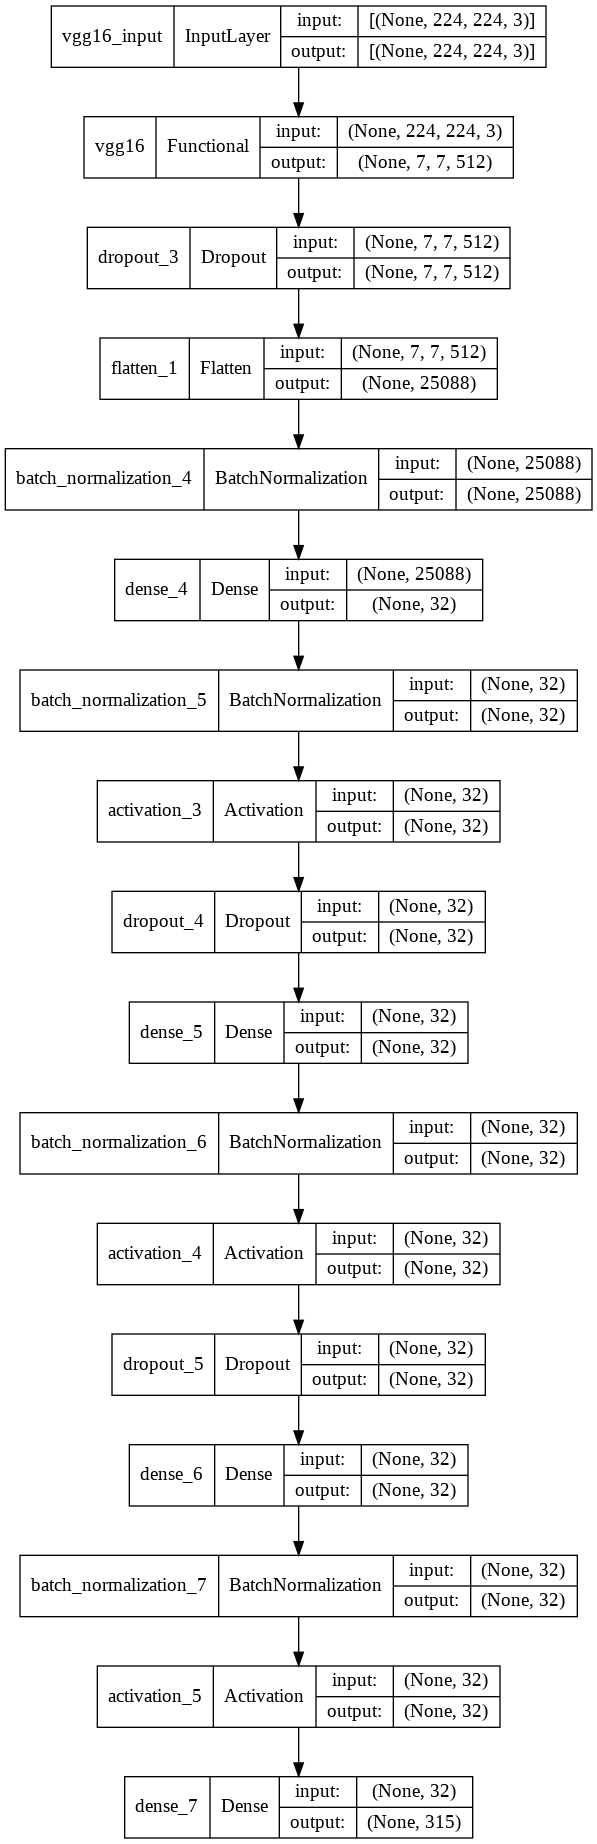

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=6)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
%time
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 5,verbose = 1)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.2 µs
Epoch 1/5
2874/2874 [==============================] - 1327s 462ms/step - loss: 5.4179 - accuracy: 0.9968 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6097 - f1_score: 0.0000e+00 - val_loss: 7.0514 - val_accuracy: 0.9968 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6641 - val_f1_score: 0.0000e+00
Epoch 2/5
2874/2874 [==============================] - 806s 281ms/step - loss: 5.2580 - accuracy: 0.9968 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6771 - f1_score: 0.0000e+00 - val_loss: 5.3038 - val_accuracy: 0.9968 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6675 - val_f1_score: 0.0000e+00
Epoch 3/5
2874/2874 [==============================] - 810s 282ms/step - loss: 5.1388 - accuracy: 0.9968 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7180 - f1_score: 0.0000e+00 - val_loss: 6.6276 - val_accuracy: 0.9968 - val_precision: 0.2500 - val_recall: 6.3492e-04 - v

In [ ]:
model.evaluate(test_dataset, verbose=1)

99/99 [==============================] - 624s 6s/step - loss: 47.2975 - accuracy: 0.9968 - precision: 0.1111 - recall: 0.0019 - auc: 0.8341 - f1_score: 0.0036


[47.297454833984375,
 0.9967836737632751,
 0.1111111119389534,
 0.0019047618843615055,
 0.8341180086135864,
 0.0035650618374347687]

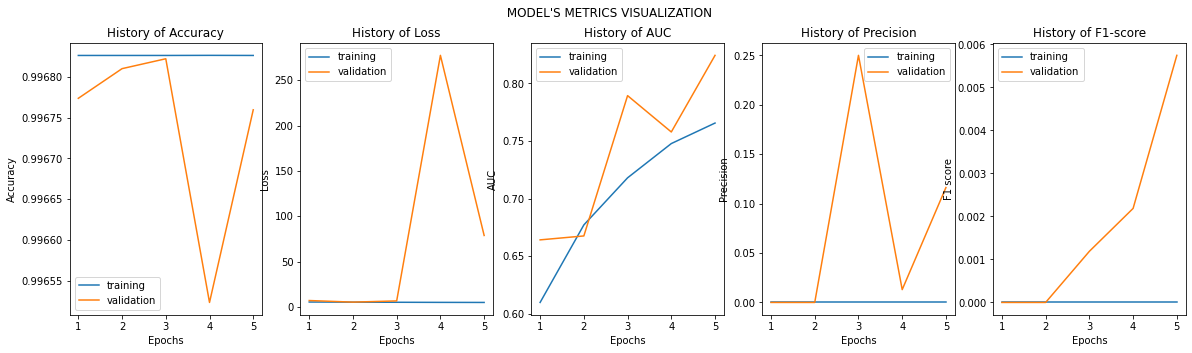

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               #history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [ ]:
import tensorflow
import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions

import numpy as np
from numpy import expand_dims
from skimage.transform import resize
import matplotlib.pyplot as pltv

In [ ]:
model = VGG16()

553476096/553467096 [==============================] - 10s 0us/step


In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# separate the classifier layer names in a list
classifier_layer_names = ['block5_pool', 'flatten', 'fc1', 'fc2', 
                          'predictions']

In [ ]:
# load the image and preprocess it
img = load_img('/content/gdrive/MyDrive/dataset/test/AFRICAN CROWNED CRANE/1.jpg', target_size=(224, 224))
img = img_to_array(img)
img = expand_dims(img, axis=0)
img = preprocess_input(img)

In [ ]:
# get the last conv layer
last_conv_layer = model.get_layer('block5_conv3')

# new model that outputs last conv layer's feature map
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [ ]:
# We create a model that maps the activations of the last conv
# layer to the final class predictions

classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
  x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [ ]:
# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer

with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [ ]:
# This is the gradient of the top predicted class with regard to
# the output feature map of the last conv layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(last_conv_layer_output, axis=-1)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

49152/35363 [=========================================] - 0s 0us/step
[('n02012849', 'crane', 0.9999864)]


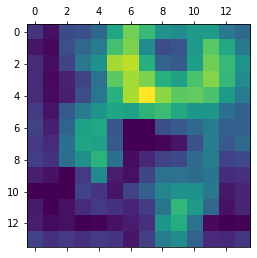

In [ ]:
# print top class prediction
print(decode_predictions(model.predict(img), top=1)[0])

# Display heatmap
plt.matshow(heatmap)
plt.show()